<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
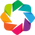

In [126]:
import xarray as xr
import hvplot.xarray
import hvplot.pandas
import numpy as np
import pandas as pd
import holoviews as hv
import geoviews as gv
import matplotlib as mpl

import geopandas as gpd
from pathlib import Path

import warnings

warnings.filterwarnings('ignore')

hv.extension('bokeh')

## Select the reservoir

In [138]:
RESERVOIR = '0505'
ALG_VERSION = 'v0.2' # calculate overall estimate of elevation for reservoir, discard rest
# ALG_VERSION = 'v0.1.1' # remove temporal resampling

RESULTS_DIR = Path(f'../results/')
DATA_DIR = Path(f'../data/')

In [139]:
# read the bounding box of the study area
### subset OF 11 reservoirs
# val_pts = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation-pts.geojson'))
# val_polys = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation.geojson'))
### all 100 reservoirs
val_pts = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/validation-reservoirs-grand.geojson'))


selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
    '1078', # Lake Mead, US,
    '0524', # Tungabhadra, India. Has both nadir and swath.
    '0486', # Sriram Sagar, India. Has both nadir and swath.
    '1284', # Sam Rayburn, US. Has both nadir and swath.
    '1385', # Pickwick Landing, US. Has both nadir and swath.
]
res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca',
    '1078': 'Lake Mead, US',
    '0524': 'Tungabhadra, In',
    '0486': 'Sriram Sagar, In',
    '1284': 'Sam Rayburn, US',
    '1385': 'Pickwick Landing, US',
}

RESERVOIR_NAME = res_names[RESERVOIR]

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

global_map = (
    val_res_pt.hvplot(
        geo=True, tiles='OSM'
    ) * val_res_pt[val_res_pt['tmsos_id'] == RESERVOIR].hvplot(
        geo=True, color='red', size=100, 
    )
).opts(
    title=f"Locations of validation reservoirs. {RESERVOIR_NAME}, highlighted in red"
)

global_map

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

In [140]:
(val_res_poly[val_res_poly['tmsos_id'] == RESERVOIR].hvplot(
    geo=True, tiles='OSM', shared_axes=False
)).opts(title=f"{RESERVOIR_NAME}")

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [141]:
BUFFER_M = 800 # m

utm_crs = val_polys[val_polys['tmsos_id'] == RESERVOIR].estimate_utm_crs()
print(f"UTM area of use: \n{utm_crs.area_of_use}")

buffered_roi_utm = val_res_poly[val_res_poly['tmsos_id'] == RESERVOIR].to_crs(utm_crs).buffer(BUFFER_M).to_crs('epsg:4326')
buffered_roi = buffered_roi_utm.to_crs('epsg:4326')

UTM area of use: 
- name: Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.
- bounds: (90.0, 0.0, 96.0, 84.0)


In [142]:
gd_track_fn = Path('../data/swot_orbit/swot_orbit.geojson')
gd_track = gpd.read_file(gd_track_fn)
gd_track

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"MULTIPOLYGON (((-75.4587 -77.45455, -75.73434 ..."
1,2,Day 01 00:51:30,"MULTIPOLYGON (((84.56768 77.75119, 84.6008 78...."
2,2,Day 01 00:51:30,"MULTIPOLYGON (((-180 -52.37417, -180 -50.92787..."
3,3,Day 01 01:42:50,"MULTIPOLYGON (((-110.19573 -77.57156, -110.161..."
4,4,Day 01 02:34:20,"MULTIPOLYGON (((57.70091 77.75254, 57.69643 78..."
...,...,...,...
845,582,Day 21 18:10:40,"MULTIPOLYGON (((136.37126 77.75111, 136.40526 ..."
846,582,Day 21 18:10:40,"MULTIPOLYGON (((-180 72.80747, -180 73.45033, ..."
847,583,Day 21 19:02:00,"MULTIPOLYGON (((-58.39258 -77.57164, -58.3595 ..."
848,584,Day 21 19:53:30,"MULTIPOLYGON (((109.50449 77.75255, 109.5009 7..."


In [143]:
gd_nadir_fn = Path('/tiger1/pdas47/tmsosPP/data/swot_orbit/sph_science_nadir/swot_science_orbit_sept2015-v2_nadir.shp')
gd_nadir = gpd.read_file(gd_nadir_fn)
gd_nadir.head()

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"LINESTRING (-75.40128 -77.54325, -67.74948 -77..."
1,2,Day 01 00:51:30,"LINESTRING (84.56135 77.66162, 92.5227 77.5155..."
2,2,Day 01 00:51:30,"LINESTRING (-180 -52.65544, -179.4133 -53.7198..."
3,3,Day 01 01:42:50,"LINESTRING (-110.20279 -77.66112, -107.53758 -..."
4,4,Day 01 02:34:20,"LINESTRING (57.70176 77.66297, 60.37721 77.650..."


In [144]:
buffered_roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1) # .hvplot(alpha=0.2, lw=2)
buffered_roi_gdf.set_geometry('geometry', inplace=True)

In [145]:
import hvplot.pandas
import geoviews as gv
from holoviews import opts
import matplotlib as mpl
from shapely.geometry import box


gd_track_subset = gd_track[gd_track.intersects(buffered_roi.geometry.values[0])]
gd_nadir_subset = gd_nadir[gd_nadir.ID_PASS.isin(gd_track_subset.ID_PASS)]
gd_nadir_20km = gd_nadir_subset.to_crs(utm_crs).buffer(10000, cap_style='flat').to_crs('epsg:4326')
gd_nadir_20km = gpd.GeoDataFrame(gd_nadir_20km)
gd_nadir_20km = gd_nadir_20km.rename({0: 'geometry'}, axis=1)
gd_nadir_20km.set_geometry('geometry', inplace=True)

roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME
roi_hv = roi_gdf.hvplot(geo=True, color='gray')

plot_lims = buffered_roi.buffer(0.5).bounds
minx = plot_lims.values[0][0]
maxx = plot_lims.values[0][2]
miny = plot_lims.values[0][1]
maxy = plot_lims.values[0][3]

xlim=(minx, maxx)
ylim=(miny, maxy)
view_bounds = box(xlim[0], ylim[0], xlim[1], ylim[1])

cmap = mpl.colormaps['Set1'].resampled(len(gd_track_subset['ID_PASS'].unique()))
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('ID_PASS')))]
tracks_hv = gd_track_subset.clip(view_bounds).hvplot(
    geo=True, tiles='OSM', 
    color=gd_track_subset['color'], 
    alpha=0.5, line_width=2,
    xlim=xlim,
    ylim=ylim,
    tools=['hover'], hover_cols=['ID_PASS']
)

nadir_hv = gd_nadir_20km.hvplot(
    geo=True, alpha=0.5, line_width=2, color='white', 
    # xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1),
    # ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1),
    xlim = (minx, maxx),
    ylim = (miny, maxy)
)

(tracks_hv * nadir_hv * roi_hv).opts(
    title=f"SWOT Ground Tracks over {RESERVOIR_NAME}", width=400
)

:Overlay
   .WMTS.I       :WMTS   [Longitude,Latitude]
   .Polygons.I   :Polygons   [Longitude,Latitude]   (_color,ID_PASS)
   .Polygons.II  :Polygons   [Longitude,Latitude]
   .Polygons.III :Polygons   [Longitude,Latitude]

In [146]:
gd_track_subset

,ID_PASS,START_TIME,geometry,color
332,230,Day 09 04:21:20,"MULTIPOLYGON (((12.32584 77.75254, 12.33066 78...",#e41a1c
677,467,Day 17 15:34:10,"MULTIPOLYGON (((3.24679 -77.57162, 3.28003 -77...",#999999


### load data

In [147]:
# load
from pathlib import Path
import pandas as pd

swot_save_dir = Path('/tiger1/pdas47/tmsosPP/data/swot')
swot_save_dir.mkdir(exist_ok=True)

dsses = []
reservoirs = []
available = []
platforms = []
times = []
ds_dict = {reservoir_id: None for reservoir_id in selected_reservoirs}

for reservoir_id in selected_reservoirs:
    fp = swot_save_dir / f'{reservoir_id}.nc'

    if not fp.exists():
        reservoirs.append(reservoir_id)
        dsses.append(None)
        available.append(False)
        platforms.append(None)
        times.append(None)
        continue
    
    ds = xr.open_dataset(fp, chunks='auto', engine='netcdf4', decode_coords='all', )
    dsses.append(ds)
    reservoirs.extend([reservoir_id] * len(ds.time))
    available.extend([True] * len(ds.time))
    platforms.extend(['swot'] * len(ds.time))
    times.extend(ds.time.values)

ds = xr.concat(filter(lambda ds: ds is not None, dsses), dim='time').sortby('time')
ds_dict[reservoir_id] = ds

df = pd.DataFrame({
    'reservoir': reservoirs,
    'available': available,
    'platform': platforms,
    'time': times,
})

ds_dict = {f'{tmsos_id}': ds for tmsos_id, ds in zip(selected_reservoirs, dsses)}
df = pd.merge(df, val_res_poly[['tmsos_id', 'geometry']], left_on='reservoir', right_on='tmsos_id', suffixes=(False, False))
df = df.sort_values('time')
df.head()

,reservoir,available,platform,time,tmsos_id,geometry
405,0486,True,swot,2023-04-08,0486,"POLYGON ((78.15373 19.09307, 78.15711 19.088, ..."
245,0936,True,swot,2023-04-08,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."
246,0936,True,swot,2023-04-09,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."
406,0486,True,swot,2023-04-09,0486,"POLYGON ((78.15373 19.09307, 78.15711 19.088, ..."
247,0936,True,swot,2023-04-10,0936,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."


Text(0.5, 1.0, 'SWOT Data downloaded for selected reservoirs')

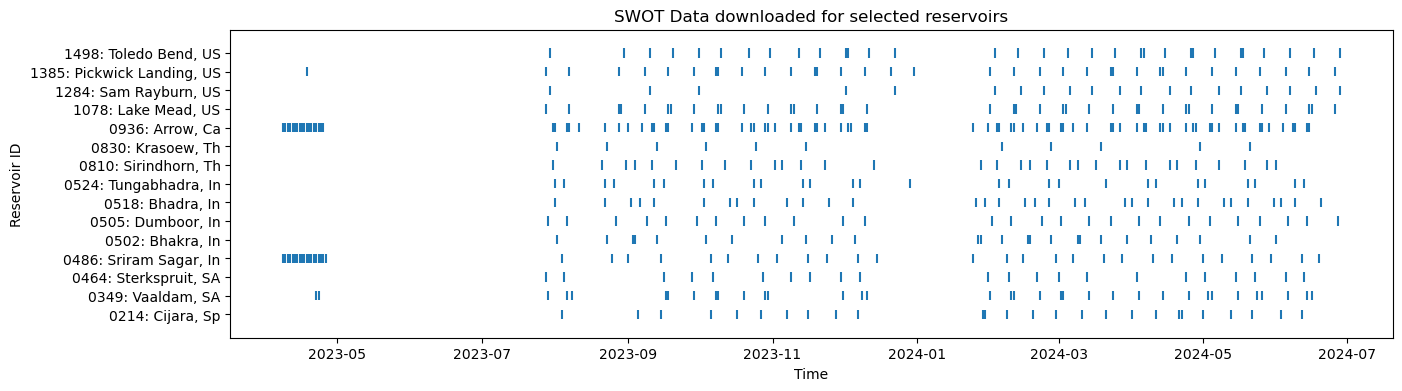

In [148]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 4))

yticks = []
ytick_labels = []
for i, reservoir_id in enumerate(df.groupby('reservoir').groups):
    data = df.loc[df['reservoir'] == reservoir_id]['time'].reset_index(drop=True)
    name = res_names[reservoir_id]
    ax.eventplot(data, orientation='horizontal', linelengths=0.5, lineoffsets=i)
    yticks.append(i)
    ytick_labels.append(f"{reservoir_id}: {name}")

ax.set_yticks(ticks=yticks, labels=ytick_labels)
ax.set_ylabel('Reservoir ID')
ax.set_xlabel('Time')

ax.set_title('SWOT Data downloaded for selected reservoirs')

## plot data for a single reservoir

In [149]:
ds = ds_dict[RESERVOIR]
ds

<xarray.Dataset> Size: 16MB
Dimensions:            (time: 27, y: 162, x: 131)
Coordinates:
  * x                  (x) float64 1kB 3.764e+05 3.765e+05 ... 3.894e+05
  * y                  (y) float64 1kB 2.591e+06 2.591e+06 ... 2.607e+06
    reservoir          <U4 16B ...
    spatial_ref        int64 8B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 216B 2023-07-29 ... 2024-06-27
Data variables:
    water_area         (time, y, x) float32 2MB dask.array<chunksize=(27, 162, 131), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 2MB dask.array<chunksize=(27, 162, 131), meta=np.ndarray>
    water_frac         (time, y, x) float32 2MB dask.array<chunksize=(27, 162, 131), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 2MB dask.array<chunksize=(27, 162, 131), meta=np.ndarray>
    wse                (time, y, x) float32 2MB dask.array<chunksize=(27, 162, 131), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 2MB dask.array<chunksize=(27, 162, 131), meta=np.ndarray>
    wse_qual           (time, y, x) float32 2MB dask.array<chunksize=(27, 162, 131), meta=np.ndarray>
    pass_ids           (time) <U3 324B dask.array<chunksize=(27,), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T12:41:47Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            Q
    x_min:                         325700.0
    x_max:                         472900.0
    y_min:                         2518700.0
    y_max:                         2665800.0
    product_version:               01

In [152]:
import holoviews as hv
import hvplot.xarray

ds['wse'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Surface Elevation (m)'
) + ds['wse_qual'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Surface Elevation Quality'
)

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [x,y]   (wse)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [x,y]   (wse_qual)

In [153]:
import holoviews as hv

ds['water_frac'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Fraction'
) + ds['water_frac_uncert'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Fraction Uncertainty'
)

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [x,y]   (water_frac)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [x,y]   (water_frac_uncert)

In [154]:
import holoviews as hv

ds['water_area'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1e4) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Area'
) + ds['water_area_qual'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 3), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Area Quality (0=nominal,1=suspect,2=degraded,3=bad)'
)

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [x,y]   (water_area)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [x,y]   (water_area_qual)

## Classify water for single reservoir

In [155]:
import rioxarray

ds = ds.rio.set_spatial_dims('y', 'x')
ds = ds.rio.write_crs(utm_crs)
ds = ds.rio.clip(buffered_roi.to_crs(ds.rio.crs).geometry.values)
ds

<xarray.Dataset> Size: 11MB
Dimensions:            (x: 107, y: 138, time: 27)
Coordinates:
  * x                  (x) float64 856B 3.776e+05 3.777e+05 ... 3.882e+05
  * y                  (y) float64 1kB 2.592e+06 2.592e+06 ... 2.606e+06
    reservoir          <U4 16B ...
    crs                int64 8B ...
  * time               (time) datetime64[ns] 216B 2023-07-29 ... 2024-06-27
    spatial_ref        int64 8B 0
Data variables:
    water_area         (time, y, x) float32 2MB dask.array<chunksize=(27, 138, 107), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 2MB dask.array<chunksize=(27, 138, 107), meta=np.ndarray>
    water_frac         (time, y, x) float32 2MB dask.array<chunksize=(27, 138, 107), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 2MB dask.array<chunksize=(27, 138, 107), meta=np.ndarray>
    wse                (time, y, x) float32 2MB dask.array<chunksize=(27, 138, 107), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 2MB dask.array<chunksize=(27, 138, 107), meta=np.ndarray>
    wse_qual           (time, y, x) float32 2MB dask.array<chunksize=(27, 138, 107), meta=np.ndarray>
    pass_ids           (time) <U3 324B dask.array<chunksize=(27,), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T12:41:47Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            Q
    x_min:                         325700.0
    x_max:                         472900.0
    y_min:                         2518700.0
    y_max:                         2665800.0
    product_version:               01

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
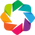

ROI CRS:  epsg:4326
roi (epsg:4326) total bounds:  [91.80090404 23.43194804 91.90540145 23.55597079]
tile limits:  80 20 90 30
tiles:  ['80E_20N', '80E_30N', '90E_20N', '90E_30N']


<xarray.DataArray 'occurrence' (y: 138, x: 107)> Size: 118kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 856B 3.776e+05 3.777e+05 ... 3.881e+05 3.882e+05
  * y            (y) float64 1kB 2.592e+06 2.592e+06 ... 2.605e+06 2.606e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [156]:
from rasterio.crs import CRS
import rioxarray
import dask
import numpy as np
from tmsswot.data import get_occurrence_like

hv.extension('bokeh')

pekel_dir = Path('../data/pekel/occurrence_nc')
occurrence = get_occurrence_like(buffered_roi, reproject_match=ds['water_frac'], pekel_dir=pekel_dir, stretching_factor=1)
occurrence

In [157]:
occurrence.hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 100), geo=True, # crs=ds.rio.crs
).opts(
    title='Occurrence (%)'
)

:DynamicMap   []
   :Image   [x,y]   (occurrence)

In [158]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
def classify_swot_raster_area(
        swot_ds, 
        roi, 
        occurrence, 
        water_frac_threshold=0.7, 
        area_qual_threshold=2, 
        zg_omega=0.3
    ):  
    swot_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    swot_ds.rio.write_crs(CRS.from_wkt(swot_ds.spatial_ref.attrs['crs_wkt']), inplace=True)

    # water-area
    water_map = (swot_ds['water_frac'].where(swot_ds['water_area_qual'] <= area_qual_threshold) > water_frac_threshold) * 1
    water_map = water_map > water_frac_threshold
    water_map = xr.where(~np.isnan(swot_ds['water_frac']).data, water_map, np.nan)
    water_map = water_map.rio.set_crs(swot_ds.rio.crs)
    water_map.attrs['standard_name'] = "surface_water"
    water_map.attrs['long_name'] = "Surface water of lake/reservoir observed by SWOT"
    water_map = water_map.rename('surface_water')

    # missing data
    missing_mask = xr.DataArray(data=np.isnan(water_map), dims=water_map.dims, coords=water_map.coords, name='missing_mask_area')
    
    # enhance using historical occurrence data
    def zg(water_map_block):
        times = water_map_block.time
        res = xr.zeros_like(water_map_block)

        for i, time in enumerate(times):
            water_map_slice = water_map_block.sel(time=time)
            if missing_fraction.sel(time=time) <= 0.95:
                mask_slice = missing_mask.sel(time=time)
                
                occurrence_slice = xr.where(~mask_slice, occurrence, np.nan)
                occurrence_slice = xr.where(water_map_slice==1, occurrence_slice, 0)
                occurrence_counts, occurrence_values = np.histogram(occurrence_slice.values, bins=99, range=(1, 100))
                count_threshold = np.nanmean(occurrence_counts) * zg_omega
                occurrence_idx = np.nanargmax(np.where(occurrence_counts > count_threshold) if (occurrence_counts > count_threshold).sum() > 0 else [0])
                occurrence_idx = np.nan if occurrence_idx == 0 else occurrence_idx
                
                pekel_estimated_map = (occurrence >= occurrence_idx)
        
                corrected_map = xr.where(
                    missing_mask['missing_mask'].sel(time=time) == 1, 
                    pekel_estimated_map,
                    water_map_slice
                )
                res.data[i] = corrected_map
            else:
                res.data[i] = np.full_like(water_map_slice, 2)
        return res

    water_map = water_map.chunk({'time': 50, 'x': -1, 'y': -1})
    water_map = water_map.transpose('time', 'y', 'x')
    water_map_uncorrected = water_map.copy()

    missing_fraction = missing_mask['missing_mask'].sum(dim=('x', 'y')).values / missing_mask['missing_mask'].size
    missing_fraction = xr.DataArray(
        data=(missing_fraction - missing_fraction.min())/(missing_fraction.max() - missing_fraction.min()), 
        dims=['time'], coords={'time': water_map.time}, name='missing_fraction')
    missing_fraction = missing_fraction.rename('missing_fraction')
    missing_fraction.attrs['standard_name'] = "missing_fraction"
    missing_fraction.attrs['long_name'] = "Fraction of data missing over the lake/reservoir observed by SWOT"
    missing_fraction.attrs['unit'] = "1"

    water_map = water_map.map_blocks(
        zg, template=water_map
    ).rename("surface_water")
    water_map.rio.set_nodata(2, inplace=True)

    water_map_area = xr.where(water_map!=1, np.nan, swot_ds['water_frac']).sum(dim=('x', 'y')) * 1e-6 * 1e4 # km^2
    water_map_area.attrs['standard_name'] = "surface_water_area"
    water_map_area.attrs['long_name'] = "Surface water area of lake/reservoir observed by SWOT"
    water_map_area.attrs['unit'] = "km^2"
    water_map_area = water_map_area.rename('surface_water_area')

    water_missing_fraction = missing_fraction
    water_missing_fraction.attrs['standard_name'] = "missing_fraction"
    water_missing_fraction.attrs['long_name'] = "Fraction of data missing over the lake/reservoir observed by SWOT"
    water_missing_fraction.attrs['unit'] = "1"
    water_missing_fraction = water_missing_fraction.rename('missing_fraction')


    swot_ds = xr.merge([
        water_map, 
        water_map_area, 
        water_missing_fraction, 
    ])
    
    swot_ds['surface_water_area'] = xr.where(missing_fraction > 0.9, np.nan, swot_ds['surface_water_area'])
    
    return swot_ds


def classify_swot_raster_elevation(
        swot_ds, 
        roi, 
        wse_qual_threshold=1, 
    ):
    swot_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    swot_ds.rio.write_crs(CRS.from_wkt(swot_ds.spatial_ref.attrs['crs_wkt']), inplace=True)

    water_surface_elevation_mask = (
        np.logical_or(np.isnan(swot_ds['wse']), swot_ds['wse_qual'] > wse_qual_threshold)
    ).rename('surface_water_elevation_raster_mask')
    water_surface_elevation_mask.attrs['standard_name'] = "surface_water_elevation_raster_mask"
    water_surface_elevation_mask.attrs['long_name'] = "Mask used to mask out poor quality water surface elevation raster. Includes nodata values in input raster."
    water_surface_elevation_mask.attrs['unit'] = '-'
    water_surface_elevation_mask.attrs['wse_qual_threshold'] = wse_qual_threshold
    
    water_surface_elevation_raster = swot_ds['wse'].where(~water_surface_elevation_mask).rename('surface_water_elevation_raster')
    water_surface_elevation_raster.attrs['standard_name'] = "surface_water_elevation_raster"
    water_surface_elevation_raster.attrs['long_name'] = "Surface water elevation of lake/reservoir observed by SWOT"
    water_surface_elevation_raster.attrs['unit'] = "m"

    water_surface_elevation = water_surface_elevation_raster.median(dim=['x', 'y'])
    water_surface_elevation.attrs['standard_name'] = "surface_water_elevation"
    water_surface_elevation.attrs['long_name'] = "Water Surface Elevation observed by SWOT"
    water_surface_elevation.attrs['unit'] = "m"
    water_surface_elevation = water_surface_elevation.rename('surface_water_elevation')

    quantiles = water_surface_elevation_raster.chunk(-1).quantile([0.25, 0.75], dim=('x', 'y'))
    iqr_filtered = water_surface_elevation_raster.where((water_surface_elevation_raster <= quantiles.sel(quantile=0.75))& (water_surface_elevation_raster >= quantiles.sel(quantile=0.25)))
    elevation_reservoir = iqr_filtered.mean(dim=('x', 'y')).rename('elevation')
    
    swot_ds_classified = xr.merge([
        elevation_reservoir
    ])

    swot_ds_classified['pass_ids'] = swot_ds['pass_ids']

    return swot_ds_classified

In [160]:
# from tmsswot.classify import classify_swot

swot_elev_ds = classify_swot_raster_elevation(
    ds, buffered_roi,
    wse_qual_threshold=1
)
swot_elev_ds

<xarray.Dataset> Size: 680B
Dimensions:      (time: 27)
Coordinates:
    reservoir    <U4 16B '0505'
    crs          int64 8B 0
  * time         (time) datetime64[ns] 216B 2023-07-29 2023-08-06 ... 2024-06-27
    spatial_ref  int64 8B 0
Data variables:
    elevation    (time) float32 108B dask.array<chunksize=(27,), meta=np.ndarray>
    pass_ids     (time) <U3 324B dask.array<chunksize=(27,), meta=np.ndarray>

In [165]:
swot_elev_ds.hvplot(x='time', y='elevation', kind='scatter', by='pass_ids')

:NdOverlay   [pass_ids]
   :Scatter   [time]   (elevation)

save data.

In [174]:
save_fp = DATA_DIR / 'swot' / 'output' / f'{RESERVOIR}_swot_{ALG_VERSION}.nc'
swot_elev_ds.to_netcdf(save_fp)
print(f'saved at {save_fp}')

saved at ../data/swot/output/0505_swot_v0.2.nc


In [175]:
csv_save_fp = save_fp.with_suffix('.csv')
swot_elev_ds.to_pandas()[['reservoir', 'elevation', 'pass_ids']].reset_index().to_csv(csv_save_fp, index=False)
print(f'saved at {csv_save_fp}')

saved at ../data/swot/output/0505_swot_v0.2.csv


##### end of notebook